# Value Iterations for Optimal Lockdown

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize

%matplotlib inline

#### Parameter Assignments 
Set at default settings, can be adjusted to fit a different situation

In [2]:
dt = 1                      # change in time (one day)
gamma = 1.0/18              # recovery/death rate for group
theta = 0.75                # level of obedience
L_max = np.array([0.7,1])   # max amount of lockdown possible
M = 2                       # number of groups

P = np.array([0.818, 0.182])     # population of each group
w = np.array([1,0])              # productivity in normal times
career = np.array([20*365, 0])   # length of remaining career, on avg.

ir = 0.00001/365                 # daily interest rate
chi = np.ones(2) * 0.20          # non-pecuniary value of life

ICU_max = 0.0003                # ICU capacity (based on 30 beds/100,000 people)
iota = np.array([0.02, 0.11])   # percentage of infected that are sent to ICU

nu = 0.667/365   # probability of vaccine/cure arrival (expected arrival 1.5 years)
beta_0 = 0.2     # initial rate of viral transmission
rho_0 = 0.75     # level of inter-group interaction

alpha_I = 1         # if everyone infected, can reduce transmission to e^(-alpha_I)
wfh = 0.40          # percent of employees able to work from home
alpha_L = 0.00001   # indirect deaths by lockdown level (75000 + 30000)/325 million/100
alpha_E = 0.42      # employment loss
eta = 10000         # penalty for exceeding ICU capacity
F = 1               # constant for future deaths due to missed health screenings, only part of financial calculations

### Setting up the Value Iteration Framework

We want to maximize the objective function (denoted `g`) over the interval `[0, L_max]`

Returns the minimum value and the minimizer.

In [3]:
def minimize_wrap(g, bds, args):

    objective = lambda x: g(x, *args)
    result = minimize(objective, np.array([0,1]), method='L-BFGS-B', jac = None, bounds=bds)
    minimizer, minimum = result.x, result.fun
    return minimizer, minimum

Next we set up the class `Model` which holds the actual function to be maximized, `obj-func`, and the grids for the susceptible and infected populations

In [4]:
class Model:

    def __init__(self,
                 u,             # utility function
                 f,             # production function
                 grid_size     # number of grid points
                 ):

        self.u, self.f = u, f

        # Set up grid
        self.gridS = np.linspace(1e-4, 1, grid_size)
        self.gridI = np.linspace(1e-4, 0.5, grid_size)


    def obj_func(self, c, y, v_array):

        u, f = self.u, self.f

        v = RegularGridInterpolator((self.gridS, self.gridS, self.gridI, self.gridI), v_array, method = 'linear')
        (s0, i0, r0, d0) = f(c, y)
        value = u(c,y)*dt + np.exp(-(nu+ir)*dt) * v(np.concatenate((s0, i0)))

        return value


`T(v, og)` updates the guess of the value function and computes the optimal lockdown policy  
  - `og` is an instance of Model (the class holding the optimization info)
  - `v` is an array representing the current guess of the value function
  
 It returns an updated guess for the value function

In [5]:
def T(v, og):

    v_new = np.empty_like(v)
    v_greedy = np.zeros((N, N, N, N, 2))

    bds = [(1e-4, L_max[0]), (1e-4, L_max[1])]

    sy,so,iy,io = 0,0,0,0

    for i in range(len(og.gridS)):
        for j in range(len(og.gridS)):
            for k in range(len(og.gridI)):
                for l in range(len(og.gridI)):
                    bellman = np.array([[og.gridS[i], og.gridS[j]],[og.gridI[k], og.gridI[l]]])
                    b2 = np.sum(bellman, axis = 0)
                    if(b2[0] <= (P[0] + 0.02) and b2[1] <= (P[1] + 0.02)):
                        if(np.sum(bellman) >= 0.4):
                            c_star, v_max = minimize_wrap(og.obj_func, bds, (bellman, v))
                            v_greedy[i][j][k][l] = c_star
                            v_new[i][j][k][l] = v_max
                            sy,so,iy,io = i, j, k, l
                        else:
                            v_greedy[i][j][k][l] = np.zeros(2)
                            v_new[i][j][k][l] = 0

                    else: # exterior, set to same value as boundary
                        v_new[i][j][k][l] = v_new[sy][so][iy][io]
                        v_greedy[i][j][k][l] = v_greedy[sy][so][iy][io]

    return v_greedy, v_new

Solve model by iterating using `T`, the mapping function, such that output eventually converges to the true value function
- `og` is the Model instance
- `v0` is the initial guess of the value function
- `max_iter` is the maximum allowable number of iterations (the algorithm will terminate when it reaches this number of iterations, regardless of whether the iterations have converged)
- `tol` is the tolerance, or the maximum level of L-infinity error that will be accepted in a "converged" result

In [6]:
def solve_model(og,v0,max_iter,tol=1e-3,verbose=True,print_skip=5):

    v = v0
    iter = 0
    error = tol + 1

    while iter < max_iter and error > tol:
        v_greedy, v_new = T(v, og)
        error = np.max(np.abs(v - v_new))
        if verbose and iter % print_skip == 0:
            print(f"Error at iteration {iter} is {error}.")
        v = v_new
        iter += 1

    if iter == max_iter:
        print(f"Error at iteration {iter} is {error}.")
        print("Failed to converge!")

    if verbose and iter < max_iter:
        print(f"\nConverged in {iter} iterations.")

    return v_greedy, v_new

### Setting up the SIR Model

#### Helper Functions

`indir()` accepts L_curr, the assigned lockdown level, and returns the death rate caused indirectly by the lockdown level

In [7]:
def indir(L_curr):
    return alpha_L * L_curr

`empl()` accepts L_e, the assigned lockdown level, and returns the rate of future unemployment

In [8]:
def empl(L_e):
    return alpha_E * w * L_e

`ICU()` accepts I_i, the array of current infection levels, and returns the penalty incurred if number of ICU patients corresponding to this level exceeds the ICU capacity (ICU_max)

In [9]:
def ICU(I_i):
    ICU_curr = np.sum(I_i * iota)
    return np.maximum(0, (ICU_curr - ICU_max) * eta)
    #return (ICU_curr - ICU_max) * eta

`phi()` accepts I_i, the array of current infection levels, and returns the death rate for each group based on the total number of currently infected individuals

In [10]:
def phi(I_p):
    I_total = np.sum(I_p)
    #a = np.array([0.001*gamma, 0.01*gamma])
    #b = np.array([0.01*gamma, 0.1*gamma])
    a = np.array([0.01*gamma, 0.06*gamma])
    b = np.array([0.06*gamma, 0.1*gamma])
    return a + b * I_total

`betaBSIR()` accepts I_i, the array of current infection levels, and returns the corresponding level of infection transmission (higher infection levels = people are more careful = less transmission)

In [11]:
def betaBSIR(I_b):
    beta = beta_0*np.exp(-alpha_I*np.sum(I_b))
    rho = np.array([[1,rho_0],[rho_0,1]])
    return beta*rho

`output()` calculates the output loss caused by people staying at home and not working (as opposed to the welfare cost represented by the objective function)

In [12]:
def output(L_g, state):
    #state = [[S_y, S_o],[I_y, I_o]] 2x2 matrix

    S_g = state[0]  #length 2 array
    I_g = state[1] #length 2 array
    R_g = P - (S_g + I_g) #length 2 arrays

    if(np.sum(I_g) == 0):
        g = 0
    else:
        g = np.sum(w*L_g*(1 - wfh)*(S_g + I_g + R_g)) #lost salary

    return g

#### SIR dynamics

In [32]:
def dynamics(L_d, state):
# population levels are in absolute terms (i.e. S_y = 0.2 => 20% of ENTIRE pop)
#state = [[S_y, S_o],[I_y, I_o]] 2x2 matrix

    R_d = P - np.sum(state, axis = 0) #2D array
    S_d = state[0] #length 2 array
    I_d = state[1] #length 2 array

    beta = betaBSIR(I_d)
    deathRate = phi(I_d)    #length 2 array
    indirDeath = indir(L_d) #scalar
    recoveryRate = gamma*np.ones(M) - deathRate #length 2 array

    sum_I = np.dot(beta,((1 - theta*L_d)*I_d)) #length 2 array

    # should all be length 2 arrays
    dI = sum_I * (1 - theta * L_d) * S_d - gamma * I_d
    dS = -dI - gamma * I_d - indirDeath * S_d
    dR = recoveryRate * I_d - indirDeath * R_d
    dD = deathRate * I_d + indirDeath * (S_d + R_d)

    D_new = dt*dD
    D_new = np.minimum(D_new, 1.0)
    D_new = np.maximum(D_new, 0)

    S_new = (S_d + dt*dS)/(1 - D_new)
    S_new = np.minimum(S_new, 1.0)
    S_new = np.maximum(S_new, 1e-4)

    I_new = (I_d + dt*dI)/(1 - D_new)
    I_new = np.minimum(I_new, 0.5)
    I_new = np.maximum(I_new, 1e-4)

    R_new = (R_d + dt*dR)/(1 - D_new)
    R_new = np.minimum(R_new, 1.0)
    R_new = np.maximum(R_new, 1e-4)

    return (S_new, I_new, R_new, D_new)

### Social/Welfare Cost Function

In [33]:
def cost(L_c, state):
    #state = [[S_y, S_o],[I_y, I_o]] 2x2 matrix

    S_c = state[0]  #length 2 array
    I_c = state[1] #length 2 array
    R_c = P - (S_c + I_c) #length 2 arrays

    if(np.sum(I_c) == 0):
        cost = 0
    else:
        cost = np.sum(w*L_c*(1 - wfh)*(S_c + I_c + R_c) #lost salary
        + ((chi + w)/ir * (1 - np.exp(-ir*career))) * phi(I_c) * I_c #COVID deaths
        + (w/ir * (1 - np.exp(-ir*career))) * indir(L_c) * (F + S_c + R_c) #non-COVID deaths
        + empl(L_c)*(S_c + R_c))  #future unemployment costs
        + ICU(I_c) #cost of exceeding ICU capacity

    return cost #scalar

## Running the Optimization
This is the main part that executes the optimization 

In [34]:
N = 16 # Number of gridpoints in each direction of state space grid
it = 30 # Maximum number of iterations before exiting, regardless of convergence

og = Model(u=cost, f=dynamics, grid_size = N)

gridS = og.gridS
gridI = og.gridI

# An initial condition, just set value function to 0
v = np.zeros((len(gridS), len(gridS), len(gridI), len(gridI))) #[S_young][S_old][I_young][I_old]

v_greedy, v_solution = solve_model(og, v, max_iter = it)

Error at iteration 0 is 12.166495636396535.
Error at iteration 5 is 8.430613443715501.
Error at iteration 10 is 5.754851801945392.
Error at iteration 15 is 4.005641852997499.
Error at iteration 20 is 2.7618412859227988.
Error at iteration 25 is 1.9345686003987907.
Error at iteration 30 is 1.4996008206074407.
Failed to converge!


### Plotting a Trajectory

Set population initial conditions:   
(Initial conditions are set to be uniform across groups in the default case, but this is not required. However, note that for each population the proportions should always add up to 1.)

In [44]:
S_0 = 0.98 * np.ones(2) #initial susceptible
I_0 = 0.01 * np.ones(2) #initial infected
R_0 = 0.01 * np.ones(2) #initial recoverd
D_0 = 0 * np.ones(2) #initial death

Run dynamics

In [48]:
T_N = 300  #number of days in trajectory

D = np.zeros((T_N,M))      #dead, [day][group]
S = np.zeros((T_N,M))      #susceptible, [day][group]
I = np.zeros((T_N,M))      #infected, [day][group]
R = np.zeros((T_N,M))      #recovered, [day][group]
L_opt = np.zeros((T_N,M))  #optimal policy, [day][group]
D_cov = np.zeros((T_N,M))  #deaths due to COVID-19 only, [day][group]

#initialize arrays
S[0] = S_0
I[0] = I_0
R[0] = R_0
D[0] = D_0
D_cov[0] = D_0

#set up interpolation function for optimal lockdown policy
interpControl = RegularGridInterpolator((gridS, gridS, gridI, gridI), v_greedy, method='linear', bounds_error=False)


herd = -1  #stores herd immunity arrival time
op = 0     #keep track of output loss
social = 0 #keep track of welfare loss

#execute dynamics
for t in range(T_N-1):
    s_curr = S[t]*P
    i_curr = I[t]*P
    r_curr = R[t]*P
    d_curr = D[t]*P

    if (herd < 0 and np.sum(r_curr) >= 0.6):
        herd = t #marks the arrival of herd immunity

    try:
        if (herd > 0): 
            L_opt[t] = 0 #already reached herd immunity (helps prevent numerical diffusion)
        else:
            L_opt[t] = interpControl(np.concatenate((s_curr, i_curr))) #get optimal control
    except ValueError :
        print(s_curr)
        print(i_curr)
        print(f"ValueError at control interpolation, t = {t}")

    l_curr = L_opt[t]

    op += output(l_curr, [s_curr, i_curr])*dt
    social += cost(l_curr, [s_curr, i_curr])*dt

    (S_new, I_new, R_new, D_new) = dynamics(l_curr, [s_curr, i_curr])
    P = (P - D_new)/np.sum(P - D_new)
    I[t+1] = I_new/P
    S[t+1] = S_new/P
    D[t+1] = D_new/P + D[t]
    R[t+1] = R_new/P
    D_cov[t+1] = D_cov[t] + dt*phi(i_curr)*i_curr/P

#manually calculate last step's optimal policy
s_curr = S[T_N -1]*P
i_curr = I[T_N -1]*P
r_curr = R[T_N -1]*P
d_curr = D[T_N -1]*P

if (herd < 0 and np.sum(r_curr) >= 0.6):
    herd = T_N -1 #marks the arrival of herd immunity

try:
    if (herd > 0): 
        L_opt[T_N -1] = 0 #already reached herd immunity (helps prevent numerical diffusion)
    else:
        L_opt[T_N -1] = interpControl(np.concatenate((s_curr, i_curr))) #get optimal control
except ValueError :
    print(s_curr)
    print(i_curr)
    print(f"ValueError at control interpolation, t = {T_N -1}")

### Calculations

In [49]:
#op = op * (133.29*220958853)/(21.43*(10**10)) (old)

total_output = T_N * np.sum(P * w) # number of days considered * normalized output per day with no lockdown

op = op/total_output #represent output loss as percent of total potential output 

social = social * 63000 / (21.43*(10**10)) #represent welfare loss as percent of GDP

deaths = D[T_N - 1]*P #final total death count
deaths_cov = D_cov[T_N - 1]*P #final COVID-19 death count

D = np.transpose(D)    #[group][day]               
S = np.transpose(S)    #[group][day]                    
I = np.transpose(I)    #[group][day]                      
R = np.transpose(R)    #[group][day]                      
L_opt = np.transpose(L_opt)    #[group][day]        
D_cov = np.transpose(D_cov)    #[group][day]        

#length of lockdown for those aged 20-64
y_lockdown = L_opt[0][L_opt[0] > 1e-4]
avg_y = np.sum(y_lockdown)/len(y_lockdown)
len_y = len(y_lockdown)

#length of lockdown for those aged 65+
o_lockdown = L_opt[1][L_opt[1] > 1e-4]
avg_o = np.sum(o_lockdown)/len(o_lockdown)
len_o = len(o_lockdown)

### Plotting

In [50]:
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (20,10)
from IPython.display import display, Markdown

x = np.linspace(0, T_N*dt, T_N)

Optimal Lockdown Policy for given initial conditions

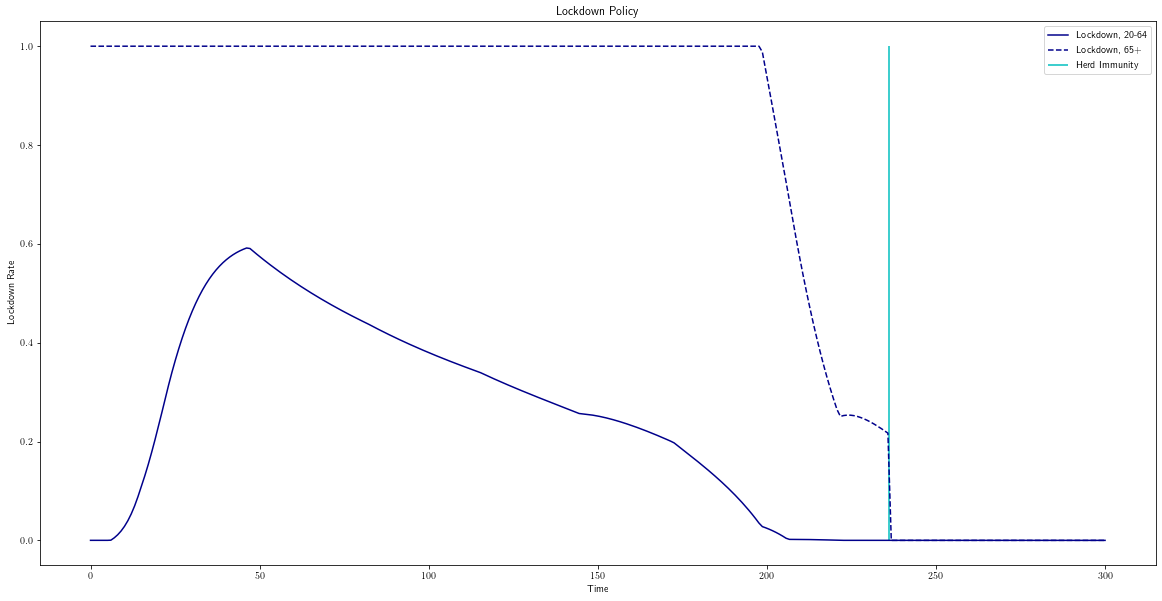

In [51]:
fig1, axs1 = plt.subplots()

L_y = axs1.plot(x,L_opt[0],marker ='', ls = 'solid', color = 'darkblue', label = 'Lockdown, 20-64')
L_o = axs1.plot(x,L_opt[1],marker ='', ls = 'dashed', color = 'darkblue', label = 'Lockdown, 65+')
if(herd>0):
    axs1.vlines(x=herd, ymin=0, ymax=1, color='c', linestyle='-', label = 'Herd Immunity')
axs1.set_xlabel('Time')
axs1.set_ylabel('Lockdown Rate')
axs1.set_title('Lockdown Policy')
axs1.legend(loc = 'best')

plt.show()

Population dynamics for given optimal policy:

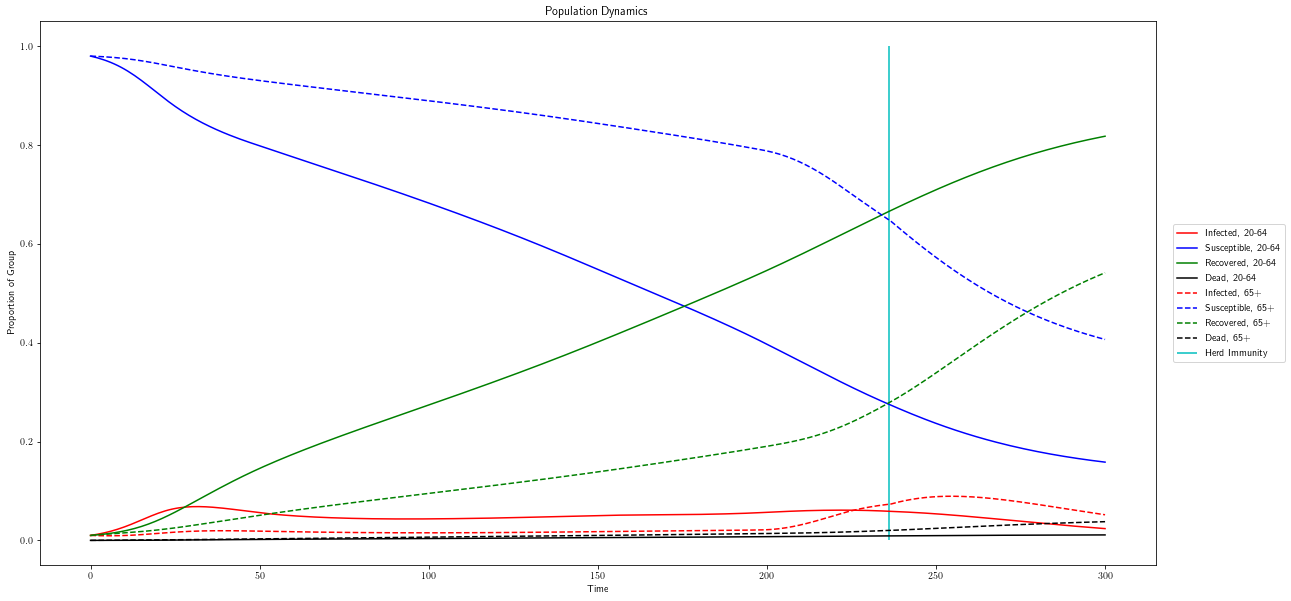

In [52]:
fig2, axs2 = plt.subplots()

I_y = axs2.plot(x,I[0],marker ='', ls = 'solid', color = 'red', label = 'Infected, 20-64')
S_y = axs2.plot(x,S[0],marker ='',  ls = 'solid', color = 'blue', label = 'Susceptible, 20-64')
R_y = axs2.plot(x,R[0],marker ='', ls = 'solid', color = 'green', label = 'Recovered, 20-64')
D_y = axs2.plot(x,D[0],marker ='', ls = 'solid', color = 'black', label = 'Dead, 20-64')

I_o = axs2.plot(x,I[1],marker ='', ls = 'dashed', color = 'red', label = 'Infected, 65+')
S_o = axs2.plot(x,S[1],marker ='',  ls = 'dashed', color = 'blue', label = 'Susceptible, 65+')
R_o = axs2.plot(x,R[1],marker ='', ls = 'dashed', color = 'green', label = 'Recovered, 65+')
D_o = axs2.plot(x,D[1],marker ='', ls = 'dashed', color = 'black', label = 'Dead, 65+')

if(herd>0):
    axs2.vlines(x=herd, ymin=0, ymax=1, color='c', linestyle='-', label = 'Herd Immunity')
axs2.set_xlabel('Time')
axs2.set_ylabel('Proportion of Group')
axs2.set_title('Population Dynamics')
axs2.legend(loc='center right', bbox_to_anchor=(1.12, 0.5))

plt.show()

A closer look at number of deaths:

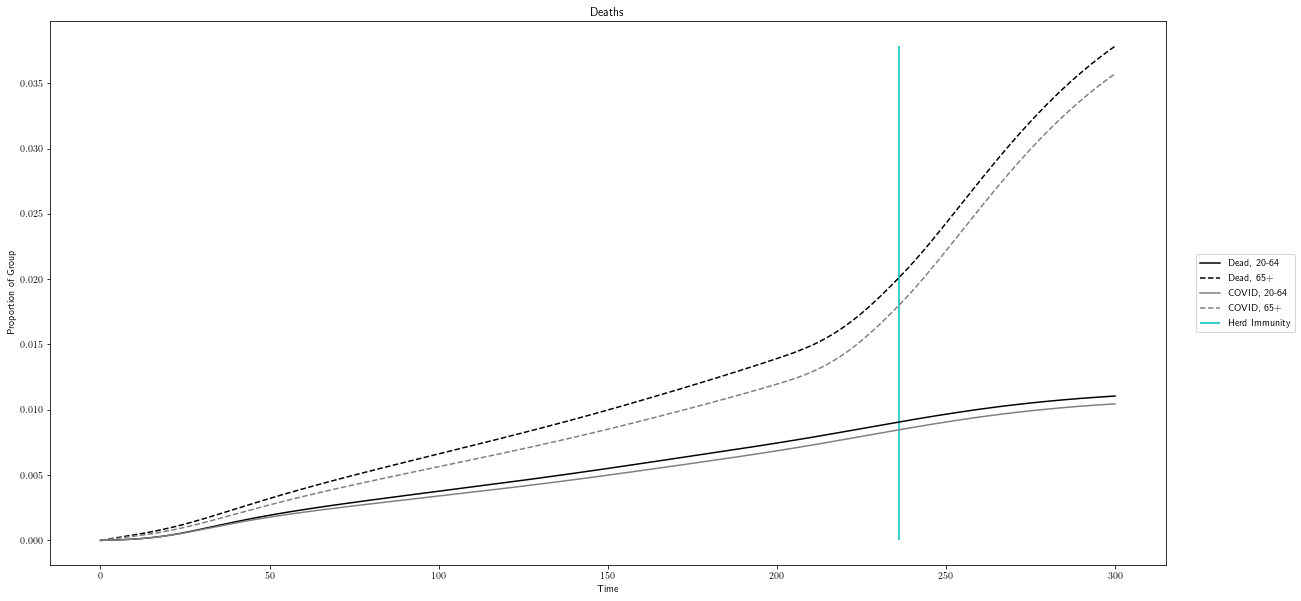

In [53]:
fig3, axs3 = plt.subplots()

D_y = axs3.plot(x,D[0],marker ='', ls = 'solid', color = 'black', label = 'Dead, 20-64')
D_o = axs3.plot(x,D[1],marker ='', ls = 'dashed', color = 'black', label = 'Dead, 65+')
C_y = axs3.plot(x,D_cov[0],marker ='', ls = 'solid', color = 'grey', label = 'COVID, 20-64')
C_o = axs3.plot(x,D_cov[1],marker ='', ls = 'dashed', color = 'grey', label = 'COVID, 65+')

if(herd>0):
    axs3.vlines(x=herd, ymin=0, ymax=np.max(D[1]), color='c', linestyle='-', label = 'Herd Immunity')
axs3.set_xlabel('Time')
axs3.set_ylabel('Proportion of Group')
axs3.set_title('Deaths')
axs3.legend(loc='center right', bbox_to_anchor=(1.12, 0.5))

plt.show()

Summary of setup and results:

In [54]:
txt1 = f'''$\\chi = {chi}$, $r = {ir*365*100}\\%$, $\\nu  = {round(nu*365, 2)}$, 
$\\alpha_L = {alpha_L}$, $\\alpha_I = {alpha_I}$, $\\alpha_E = {alpha_E}$, $\\eta = {eta}$, F = {F}, wfh = {wfh}'''

txt2 = f'''Avg. Lockdown (20-64): {round(avg_y, 4)} over {len_y} days, 
Avg. Lockdown (65+): {round(avg_o, 4)} over {len_o} days'''

txt3 = f'''Output Loss: {round(op, 4)}\\%, Social Loss: {round(social, 4)}\\%'''

txt4 = f'''COVID-19 Deaths (All): {round(np.sum(deaths_cov)*100, 4)}\\%, Total Deaths (All): {round(np.sum(deaths)*100, 4)}\\%, COVID-19 Deaths (20-64): {round(deaths_cov[0]*100, 4)}\\%, Total Deaths (20-64): {round(deaths[0]*100, 4)}\\%, 
 COVID-19 Deaths (65+): {round(deaths_cov[1]*100, 4)}\\%, Total Deaths (65+): {round(deaths[1]*100, 4)}\\%,'''

display(Markdown(txt1))
display(Markdown(txt2))
display(Markdown(txt3))
display(Markdown(txt4))

$\chi = [0.2 0.2]$, $r = 0.001\%$, $\nu  = 0.67$, 
$\alpha_L = 1e-05$, $\alpha_I = 1$, $\alpha_E = 0.42$, $\eta = 10000$, F = 1, wfh = 0.4

Avg. Lockdown (20-64): 0.2888 over 218 days, 
Avg. Lockdown (65+): 0.9122 over 236 days

Output Loss: 0.1254\%, Social Loss: 0.0\%

COVID-19 Deaths (All): 1.4725\%, Total Deaths (All): 1.5579\%, COVID-19 Deaths (20-64): 0.8684\%, Total Deaths (20-64): 0.918\%, 
 COVID-19 Deaths (65+): 0.6041\%, Total Deaths (65+): 0.6399\%,